# Interpretable Machine Learning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
import pydotplus
from IPython.display import Image  
from sklearn.inspection import plot_partial_dependence
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
import pydotplus
from IPython.display import Image  
from numpy import linalg
from sklearn.inspection import permutation_importance






def kaggle_score(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred));
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tree Models

### Feature Importances

Let us first look at feature importances in the bank marketing dataset



In [4]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
bank.shape

(45211, 17)

In [6]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [7]:
bank_majority = bank[bank.y=="no"]
bank_minority = bank[bank.y=="yes"]
 
# downsample
bank_majority_downsampled = resample(bank_majority, 
                                 replace=False,    
                                 n_samples=5289) 
 
bank_balanced = pd.concat([bank_minority, bank_majority_downsampled])
bank_balanced.y.value_counts()

yes    5289
no     5289
Name: y, dtype: int64

In [11]:
X = bank_balanced.loc[:,'age':'poutcome']
X["random_num"] = np.random.rand(X.shape[0])
X.drop(columns=['duration'], inplace=True)

y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
   

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train);

y_pred1 = clf.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       546
           1       0.63      0.68      0.65       512

    accuracy                           0.65      1058
   macro avg       0.65      0.65      0.65      1058
weighted avg       0.65      0.65      0.65      1058



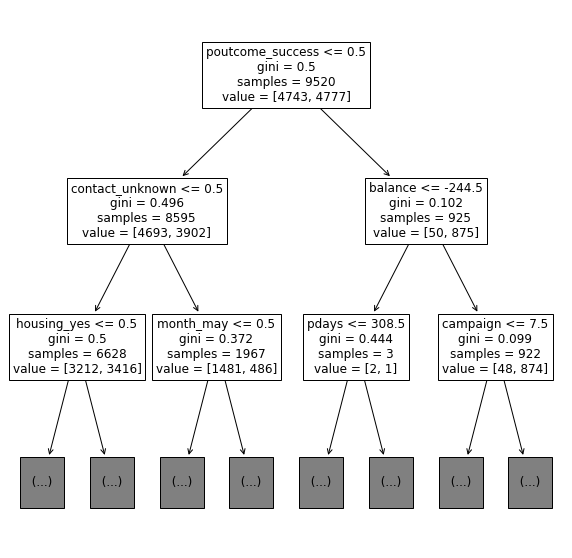

In [12]:
plt.figure(figsize=(10,10));
tree.plot_tree(clf, feature_names=X.columns,max_depth=2, fontsize=12);

### Feature importance scores

Total reduction in impurity brought by the feature (for categorical classes) and total reduction in variance brought by the feature (for numerical classes). Impurity-based feature importances can be misleading for high cardinality features.

In [13]:
imps = clf.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals}
pd.DataFrame(d)

,features,values
0,balance,0.147637
1,random_num,0.141604
2,age,0.108457
3,day,0.091220
4,poutcome_success,0.084926
5,campaign,0.054296
6,contact_unknown,0.045883
7,pdays,0.033646
8,housing_yes,0.019147
9,month_jul,0.018729


### sklearn tree structure

The entire binary tree structure is represented as a number of parallel arrays. The i-th element of each array holds information about the node i. Node 0 is the tree’s root. Nunbers are assigned in a depth-first order.

Some of these are:

- children_left[i]: id of the left child of node i or -1 if leaf node

- children_right[i]: id of the right child of node i or -1 if leaf node

- feature[i]: feature used for splitting node i

- threshold[i]: threshold value at node i

- n_node_samples[i]: the number of training samples reaching node i

- impurity[i]: the impurity at node i

For more information:
[sklearn tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)

### Feature importances from scratch

In [14]:
def MyFeatureImportance(tree, idx, imps):
    """
    :tree: Decision tree built
    :idx: Index of the root of the subtree that the importances will be calculated.
    :imps: feature importances, should be initialized to all zeros 
    :return: imps
    """
    if tree.children_left[idx] > -1:
        imps[tree.feature[idx]]+=(tree.n_node_samples[idx]*tree.impurity[idx] 
        - tree.n_node_samples[tree.children_left[idx]]*tree.impurity[tree.children_left[idx]]
        - tree.n_node_samples[tree.children_right[idx]]*tree.impurity[tree.children_right[idx]])
        
        MyFeatureImportance(tree, tree.children_left[idx], imps)
        MyFeatureImportance(tree, tree.children_right[idx], imps)
        
    return imps/np.sum(imps)

Now, let us check my_feature_importance finds the same importance values as sklearn

In [15]:
my_imps = np.zeros(clf.n_features_in_)
my_imps = MyFeatureImportance(clf.tree_,0, my_imps)
my_sorted_idx = np.argsort(my_imps)[::-1]
my_sorted_vals = np.sort(my_imps)[::-1]

d = {"features":X.columns[my_sorted_idx], "values":my_sorted_vals, "sklearn features":X.columns[sorted_idx], "sklearn values":sorted_vals}
pd.DataFrame(d)

,features,values,sklearn features,sklearn values
0,balance,0.147637,balance,0.147637
1,random_num,0.141604,random_num,0.141604
2,age,0.108457,age,0.108457
3,day,0.091220,day,0.091220
4,poutcome_success,0.084926,poutcome_success,0.084926
5,campaign,0.054296,campaign,0.054296
6,contact_unknown,0.045883,contact_unknown,0.045883
7,pdays,0.033646,pdays,0.033646
8,housing_yes,0.019147,housing_yes,0.019147
9,month_jul,0.018729,month_jul,0.018729


Let us now look at house price prediction dataset

In [16]:
# Run Regression Tree with top correlated 10 attributes with SalePrice

train = pd.read_csv("../datasets/house_prices/train.csv")
test = pd.read_csv("../datasets/house_prices/test.csv")

cors = train.corr(); 
top10 = cors.loc[:, "SalePrice"].sort_values(ascending = False).head(11)
top10 = top10.index.values.tolist()
top10.pop(0)

X = train.loc[:,top10]
y = train.loc[:,'SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    #X_train = X_train.fillna(X_train.mean())
    #X_test = X_test.fillna(X_test.mean())
regr = DecisionTreeRegressor()
model = regr.fit(X_train, y_train)
test_predictions = model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, test_predictions))



Test MAE: 26292.448630136987


In [22]:
imps = regr.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]



my_imps = np.zeros(regr.n_features_in_)
my_imps = MyFeatureImportance(regr.tree_,0, my_imps)
my_sorted_idx = np.argsort(my_imps)[::-1]
my_sorted_vals = np.sort(my_imps)[::-1]

d = {"features":X.columns[my_sorted_idx], "values":my_sorted_vals, "sklearn features":X.columns[sorted_idx], "sklearn values":sorted_vals}
pd.DataFrame(d)

,features,values,sklearn features,sklearn values
0,OverallQual,0.649805,OverallQual,0.649805
1,GrLivArea,0.116435,GrLivArea,0.116435
2,TotalBsmtSF,0.080587,TotalBsmtSF,0.080587
3,YearRemodAdd,0.046679,YearRemodAdd,0.046679
4,1stFlrSF,0.037238,1stFlrSF,0.037238
5,GarageArea,0.020190,GarageArea,0.020190
6,YearBuilt,0.018578,YearBuilt,0.018578
7,TotRmsAbvGrd,0.015045,TotRmsAbvGrd,0.015045
8,GarageCars,0.013356,GarageCars,0.013356
9,FullBath,0.002086,FullBath,0.002086


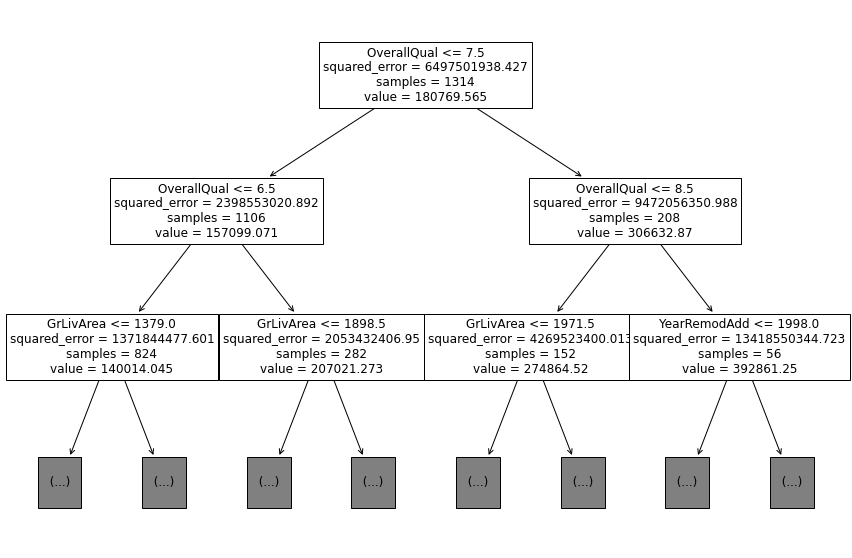

In [23]:
plt.figure(figsize=(15,10));
tree.plot_tree(regr, feature_names=X.columns,max_depth=2, fontsize=12);

### Discussion

- Feature importance scores are computed on the model which is fitted on the training set, therefore if a model overfits than the scores can be misleading. You can try to add a random feature to see this result.
- It is better to evaluate the importance of a feature on the test set. Permutation importance can help at this point.
- It is important not to forget that these scores only show the importance of a feature relative to a model. In other words how much a model relies on a feature. A feature which might not be used by a model does not mean that that feature is unimportant in general. This might happen, for example, when there are two important but correlated features. A decision tree will choose one of them and will not use the other one. This does not mean that the unused feature is not important in general.
- Permutation feature importance requires the true labels in addition to the model.
- Correlated features might create problems. Suppose that feature A is very important, if you add a correlated feature B, and then train a random forest, then some of the trees will use feature A and some of the trees will use feature B. As a result, the importance of these features will decrease.

### Permutation Importance

Permutation importance of a feature in the decrease in model score when the values of that feature are randomly shuffled.

In [28]:
X = bank_balanced.loc[:,'age':'poutcome']
X["random_num"] = np.random.rand(X.shape[0])
X.drop(columns=['duration'], inplace=True)

y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train);

y_pred1 = clf.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66       532
           1       0.65      0.64      0.64       526

    accuracy                           0.65      1058
   macro avg       0.65      0.65      0.65      1058
weighted avg       0.65      0.65      0.65      1058



In [32]:
perm_test = permutation_importance(clf, X_test, y_test)
perm_train = permutation_importance(clf, X_train, y_train)

In [34]:
imps = clf.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]

perm_imps_test = perm_test['importances_mean']
perm_sorted_idx_test = np.argsort(perm_imps_test)[::-1]
perm_sorted_vals_test = np.sort(perm_imps_test)[::-1]

perm_imps_train = perm_train['importances_mean']
perm_sorted_idx_train = np.argsort(perm_imps_train)[::-1]
perm_sorted_vals_train = np.sort(perm_imps_train)[::-1]

d = {"Perm. features Test":X.columns[perm_sorted_idx_test], "Perm. Imp. Test":perm_sorted_vals_test,"Perm. features Train":X.columns[perm_sorted_idx_train], "Perm. Imp.Train":perm_sorted_vals_train, "Feature Imp. features":X.columns[sorted_idx], "Feature Imp.":sorted_vals}
pd.DataFrame(d)

,Perm. features Test,Perm. Imp. Test,Perm. features Train,Perm. Imp.Train,Feature Imp. features,Feature Imp.
0,contact_unknown,0.039509,balance,0.224895,balance,0.142537
1,poutcome_success,0.035161,day,0.173592,random_num,0.140844
2,month_aug,0.021739,random_num,0.158866,age,0.094556
3,pdays,0.020605,contact_unknown,0.149685,day,0.093498
4,month_jun,0.020416,age,0.149034,poutcome_success,0.086487
5,month_may,0.017958,housing_yes,0.148550,campaign,0.056047
6,month_jul,0.016446,campaign,0.091996,contact_unknown,0.047424
7,month_nov,0.014178,month_may,0.071933,pdays,0.037362
8,day,0.013611,poutcome_success,0.071513,housing_yes,0.021107
9,balance,0.008507,month_aug,0.069391,month_jul,0.018281
